# Примеры со Стекингом с библиотекой Mlxtend:

Всё нагло перекопировано с http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/

# Часть 1. Стекинг классификаторов

## 1. Простой Стекинг:

In [8]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [28]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
import numpy as np
%matplotlib inline

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.95 (+/- 0.04) [StackingClassifier]


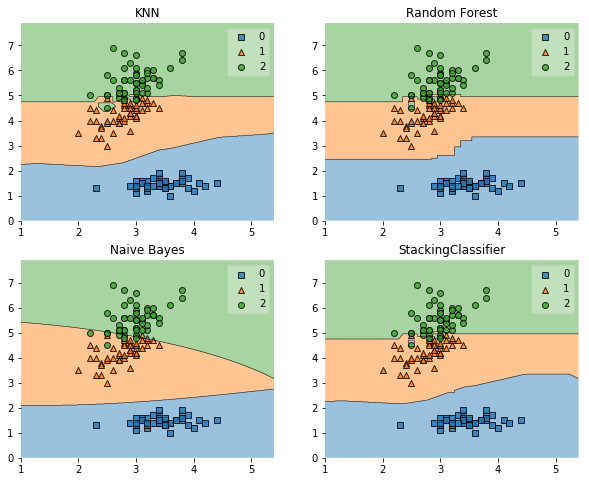

In [29]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingClassifier'],
                          itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)

# 2. Стекинг с вероятностями:

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting use_probas=True. If average_probas=True, the probabilities of the level-1 classifiers are averaged, if average_probas=False, the probabilities are stacked (recommended). For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

classifier 1: [0.2, 0.5, 0.3]
classifier 2: [0.3, 0.4, 0.4]
If average_probas=True, the meta-features would be:

[0.25, 0.45, 0.35]
In contrast, using average_probas=False results in k features where, k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

[0.2, 0.5, 0.3, 0.3, 0.4, 0.4]

In [32]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          average_probas=False,
                          meta_classifier=lr)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.93 (+/- 0.05) [Random Forest]
Accuracy: 0.92 (+/- 0.03) [Naive Bayes]
Accuracy: 0.94 (+/- 0.03) [StackingClassifier]


## 3. Стекинг + Гридсерч:

To set up a parameter grid for scikit-learn's GridSearch, we simply provide the estimator's names in the parameter grid -- in the special case of the meta-regressor, we append the 'meta-' prefix.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier__n_neighbors': [1, 5], # чтобы получить названия классификаторов: sclf.named_classifiers
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors':

Если же какой-то классификатор используется несколько раз (несколько инстансов), тогда:

In [45]:
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(n_estimators=10, random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
sclf = StackingClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                          meta_classifier=lr)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta-logisticregression__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.927 +/- 0.03 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta-logisticregression__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta-logisticregression__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.947 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'me

In [46]:
sclf.named_classifiers

{'kneighborsclassifier-1': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=1, p=2,
            weights='uniform'),
 'kneighborsclassifier-2': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=1, p=2,
            weights='uniform'),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=1, verbose=0, warm_start=False),
 'gaussiannb': GaussianNB(priors=None, var_smoothing=1e-09)}

## 4. Обучение базовых алгоритмов на разных наборах фичей:

In [48]:
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),
                      LogisticRegression(solver='lbfgs', multi_class='auto'))
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),
                      LogisticRegression(solver='lbfgs', multi_class='auto'))

sclf = StackingClassifier(classifiers=[pipe1, pipe2], 
                          meta_classifier=LogisticRegression(solver='lbfgs', multi_class='auto'))

sclf.fit(X, y)

StackingClassifier(average_probas=False,
          classifiers=[Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(cols=(0, 2), drop_axis=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None,...alty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])],
          meta_classifier=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
          store_train_meta_features=False, use_clones=True,
          use_features_in_secondary=False, use_probas=False, verbose=0)

# Часть 2. Стекинг регрессоров

## 1. Стекинг регрессоров:

In [49]:
from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np

# Generating a sample dataset
np.random.seed(1)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))

Mean Squared Error: 0.2039
Variance Score: 0.7049


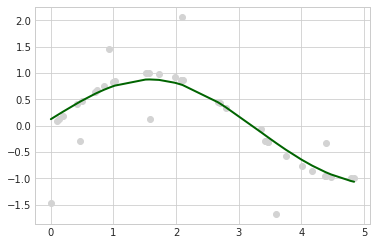

In [62]:
# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear', gamma='auto')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf', gamma='auto')

stregr = StackingRegressor(regressors=[svr_lin, lr, ridge], 
                           meta_regressor=svr_rbf)

# Training the stacking classifier

stregr.fit(X, y)
stregr.predict(X)

# Evaluate and visualize the fit

print("Mean Squared Error: %.4f"
      % np.mean((stregr.predict(X) - y) ** 2))
print('Variance Score: %.4f' % stregr.score(X, y))

with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(X, y, c='lightgray')
    plt.plot(X, stregr.predict(X), c='darkgreen', lw=2)

plt.show()

## 2. Стекинг регрессоров + GridSearch

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge, lasso]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0],
          'svr__C': [0.1, 1.0, 10.0],
          'meta-svr__C': [0.1, 1.0, 10.0, 100.0],
          'meta-svr__gamma': [0.1, 1.0, 10.0]}

grid = GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True, 
                   scoring='neg_mean_squared_error')
grid.fit(X, y)

a = grid.cv_results_['params']
b = grid.cv_results_['std_test_score']
c = grid.cv_results_['mean_test_score']

for params, mean_score, scores in zip(a,c,b):
        print("%0.3f +/- %0.2f %r"
              % (mean_score, scores, params))

-1.024 +/- 0.36 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 0.1}
-1.010 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 1.0}
-1.010 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 0.1, 'svr__C': 10.0}
-1.025 +/- 0.36 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 0.1}
-1.011 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 1.0}
-1.011 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 1.0, 'svr__C': 10.0}
-1.031 +/- 0.36 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 0.1}
-1.019 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C': 0.1, 'meta-svr__gamma': 0.1, 'ridge__alpha': 10.0, 'svr__C': 1.0}
-1.019 +/- 0.35 {'lasso__alpha': 0.1, 'meta-svr__C':

In [89]:
grid.best_estimator_

StackingRegressor(meta_regressor=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
         refit=True,
         regressors=[SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False), LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False), Ridge(alpha=0.1, copy_X=True, fit_...itive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [90]:
grid.best_params_

{'lasso__alpha': 0.1,
 'meta-svr__C': 1.0,
 'meta-svr__gamma': 1.0,
 'ridge__alpha': 0.1,
 'svr__C': 10.0}

In [91]:
grid.best_score_

-0.22961798778349438

Mean Squared Error: 0.1845
Variance Score: -0.1845


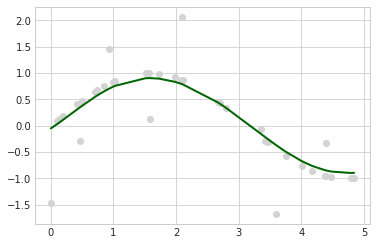

In [92]:
# Evaluate and visualize the fit
print("Mean Squared Error: %.4f"
      % np.mean((grid.predict(X) - y) ** 2))
print('Variance Score: %.4f' % grid.score(X, y))

with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(X, y, c='lightgray')
    plt.plot(X, grid.predict(X), c='darkgreen', lw=2)

plt.show()